In [72]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.timeseries import LombScargle
import scipy.signal as signal

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
tessfits = glob.glob('tess_fits_files/*fits')
tessfits

['tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits',
 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits']

Do both lc's separatly, then combine

Parameter('fwhm', value=0.4006844829616501, unit=d)
Parameter('x_0', value=1.1088221820387212, unit=d) 0.007633301480934168
Parameter('fwhm', value=0.05201628076325629, unit=d)
Parameter('x_0', value=1.1543719348527006, unit=d) 0.0017872489512859827


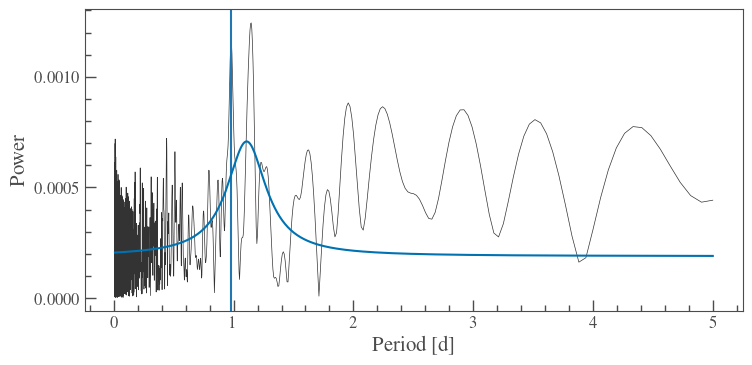

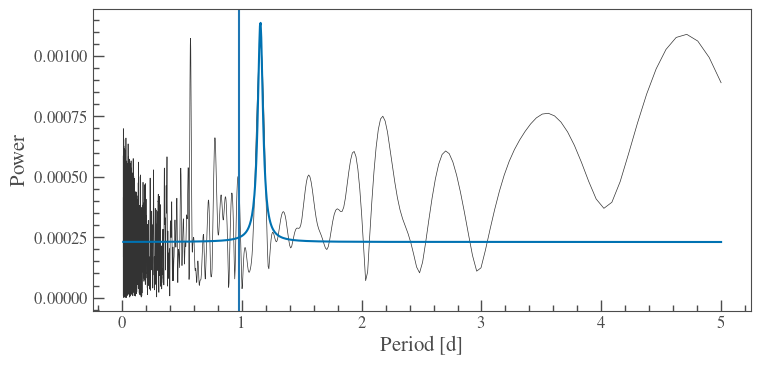

In [269]:
fitter = fitting.LevMarLSQFitter()

for i, ft in enumerate(tessfits):
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    #plt.scatter(t, f)
    #plt.show()
    t, f, e = t[q==0], f[q==0], e[q==0]
    fit = np.polyval((np.polyfit(t,f,2)), t)
    #e=e/f
    f = f/fit
    e = e/fit
    #f, e = f/np.mean(f), e/np.mean(e)
    #f = f / np.mean(f)
   # e = e/f
   # f = (f/np.mean(f)*100)-100
    #e = e*f
    lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
    #lcf, trend = lc.flatten(1000001, return_trend=True)
    #lc.scatter()
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.01*u.day, maximum_period=5*u.day)
    pg.plot()
    l_init =  models.Lorentz1D(0.001, 1.15, fwhm=0.05)+models.Const1D(0)
    #if i == 0:
     #   l_init += models.Lorentz1D(0.001, 0.9, fwhm=0.05, bounds={'fwhm':[0.0001, 1], 'x_0':[0.95, 1.2], 'amplitude':[0.001, 0.002]})
    l_fit=fitter(l_init, pg.period, pg.power, maxiter=1000000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    print(l_fit[0].fwhm)
    print(l_fit[0].x_0, fit_e[1])
   # plt.axvline(0.98)
    plt.plot(pg.period, l_fit(pg.period))

Try the her